In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import plotly_express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import PIL
import os

In [2]:
# from fastai.basics import *
from fastai.vision.all import *

In [3]:
path = '/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/'

# Initial Data Checks

In [4]:
normal_imgs_path_list = get_image_files(path+'Normal')
covid_imgs_path_list = get_image_files(path+'COVID')
viral_imgs_path_list = get_image_files(path+'Viral Pneumonia')

In [5]:
X = [*normal_imgs_path_list, *covid_imgs_path_list, *viral_imgs_path_list]
len(X)

15153

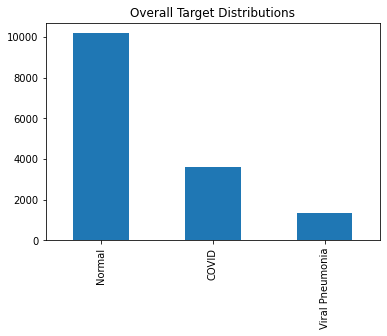

In [6]:
y=pd.Series(data=X)
y=y.apply(lambda x: str(x).split('/')[-2])
y.value_counts().plot.bar()
plt.title('Overall Target Distributions')
plt.show()

In [7]:
def show_sample(path):
    sample_image = PILImage.create(path) #using matplotlib
    plt.title(sample_image.shape) #.size gives memory usage, so use .shape
    plt.imshow(sample_image, cmap='gray')
    plt.axis("off")
    plt.show()

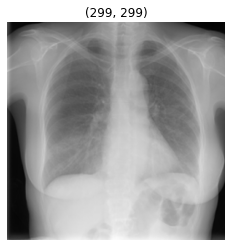

In [8]:
show_sample(covid_imgs_path_list[0])

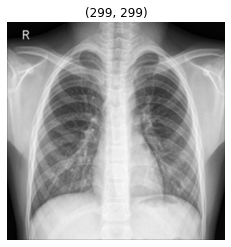

In [9]:
show_sample(normal_imgs_path_list[0])

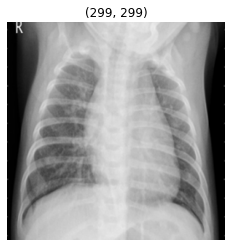

In [10]:
show_sample(viral_imgs_path_list[0])

# Splitting Data

In [11]:
from sklearn.model_selection import train_test_split
seed=3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed)
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=seed)

In [12]:
y_train.value_counts(normalize=True)

Normal             0.672579
COVID              0.238657
Viral Pneumonia    0.088764
dtype: float64

In [13]:
y_test.value_counts(normalize=True)

Normal             0.672715
COVID              0.238535
Viral Pneumonia    0.088750
dtype: float64

# Creating Dataloaders

In [14]:
bs=64 #batch size
size=[299,299] #input image size for model
vocab = list(y.unique()) #vocabulary to access string labels

In [15]:
vocab

['Normal', 'COVID', 'Viral Pneumonia']

In [16]:
items = X_train
tfms = [[PILImage.create], [parent_label, Categorize(vocab=vocab, sort=False)]]
splits = TrainTestSplitter(0.2,random_state=3,stratify=y_train)(items)
# splits = L(list(y_train.index)),L(list(y_valid.index))

In [17]:
ds = Datasets(items=items, tfms=tfms, splits=splits)

In [18]:
item_tfms = [Resize(size, method=ResizeMethod.Squish), ToTensor()]
batch_tfms = [IntToFloatTensor(), *aug_transforms(max_warp=0, flip_vert=False), Normalize.from_stats(*imagenet_stats)]

In [19]:
dls = ds.dataloaders(after_item=item_tfms, after_batch=batch_tfms, bs=bs) #complete training set
valid_dls = dls.test_dl(dls.valid_ds.items, with_labels=True) #validation data for metric comparisions
test_dls = dls.test_dl(X_test, with_labels=True) #holdout set

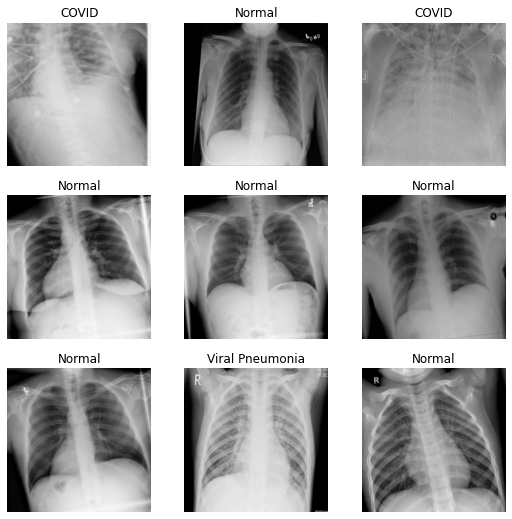

In [20]:
dls.show_batch()

# Model Building

### I will use transfer learning 
- A pre-trained model is used that was previously trained on a large dataset, typically on a large-scale image-classification task. You either use the pretrained model as is or use transfer learning to customize this model to a given task.

- The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model of the visual world. We can then take advantage of these learned feature maps without having to start from scratch.

#### To get best results:
- We just remove few last layers from pre-trained model and add our own layers, so that it can adapt to our task
- Then we freeze the pre-trained model and train only our custom 'head'
- Then we unfreeze and jointly train both the head and body (pre-trained model)


In [21]:
loss_func = CrossEntropyLossFlat()
metrics = [accuracy]
cbs = [SaveModelCallback]

In [22]:
learner = cnn_learner(dls, resnet50, metrics=metrics, cbs=cbs, loss_func=loss_func)
learner.summary()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Sequential (Input shape: 64)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 150 x 150 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
Conv2d                                    4096       False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
____________________________________________________________________________
                     64 x 256 x 75 x 75  
Conv2d                                    16384      False     
BatchNorm2d                               512        True      
ReLU                                                           
__________________________________________

### learning rate finder using callback, this will help decide best learning rate (Implemented by fastai library)
- The idea is to start with small learning rate (like 1e-4, 1e-3) and increase the learning rate after each mini-batch till loss starts exploding. Once loss starts exploding stop the range test run. Plot the learning rate vs loss plot. Choose the learning rate one order lower than the learning rate where loss is minimum( if loss is low at 0.1, good value to start is 0.01). This is the value where loss is still decreasing. Paper suggests this to be good learning rate value for model. 
ResearchPaper Reference: https://arxiv.org/pdf/1506.01186.pdf

SuggestedLRs(lr_min=0.012022644281387329, lr_steep=0.0063095735386013985)

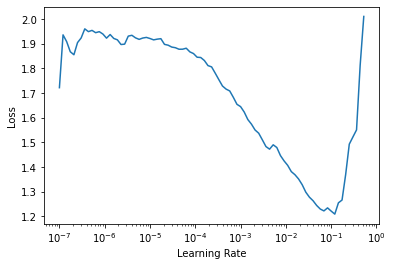

In [23]:
learner.lr_find()

### OneCycle Policy using callback (by fastai)
- Research Paper reference : https://arxiv.org/abs/1803.09820
- Idea here is to cycle the learning rate and momentum during training between a upper bound and lower bound
- Motivation for using Cyclical learning rate: Well, experiments have shown, cyclically varying the learning rate between reasonable bounds can actually increase the accuracy of the model in fewer steps. And the reason behind is:
- higher learning rates help in coming out of local minima and the lower learning rates prevents the training from diverging.

- Author reccomends to use one cycle of 2 steps of equal length, where the maximum learning rate is chosen from LR range test (found previously) and the minimum learning rate is 1/5th or 1/10th of maximum.
- We pick the cycle length slightly lesser than the total number of epochs to be trained.
- And in the last remaining iterations, we annihilate learning rate way below lower learning rate value(1/10 th or 1/100 th) [credits](https://towardsdatascience.com/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6). 

- Author found in their experiments that reducing the momentum when learning rate is increasing gives better results.
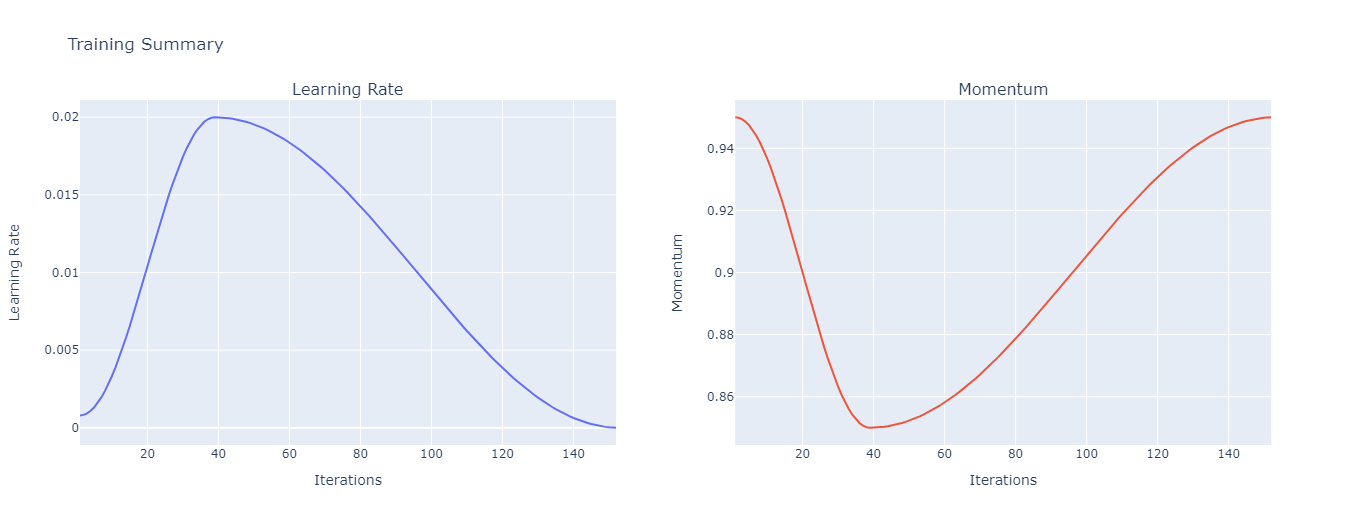

In [24]:
max_lr = 1e-2
epochs = 1
learner.fit_one_cycle(n_epoch=epochs, lr_max=max_lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.221196,0.078410,0.973608,01:42


Better model found at epoch 0 with valid_loss value: 0.07840996980667114.


In [25]:
learner.save('stage-1')

Path('models/stage-1.pth')

In [26]:
learner.unfreeze() #unfreeze the model for finetuning

SuggestedLRs(lr_min=1.9054607491852948e-07, lr_steep=7.585775847473997e-07)

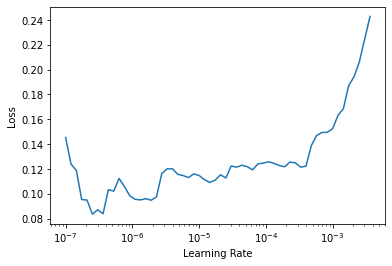

In [27]:
learner.lr_find()

- 1e-3 = train all layers using this learning rate
- slice(1e-3) = last layers are trained with 1e-3 and all the other layers with (1e-3)/3
- slice(1e-5,1e-3) = Last layers are trained with 1e-5, first layers with 1e-3, and all the others get learning rates that are equally spread between these numbers. For example, if there are three layers, learning rates will be 1e-5,1e-4,1e-3

In [28]:
max_lr = slice(1e-5,1e-3)
epochs = 10
learner.fit_one_cycle(n_epoch=epochs, lr_max=max_lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.115469,0.050436,0.987629,01:59
1,0.134488,0.108443,0.964948,01:59
2,0.100587,0.055095,0.983505,01:59
3,0.068001,0.032175,0.990103,02:00
4,0.071237,0.104411,0.965773,01:59
5,0.042060,0.036818,0.990103,01:59
6,0.032200,0.022578,0.993814,01:59
7,0.020983,0.020013,0.994639,01:59
8,0.017521,0.018635,0.995052,01:59
9,0.014558,0.017692,0.995052,02:00


Better model found at epoch 0 with valid_loss value: 0.05043572187423706.
Better model found at epoch 3 with valid_loss value: 0.032174721360206604.
Better model found at epoch 6 with valid_loss value: 0.022578362375497818.
Better model found at epoch 7 with valid_loss value: 0.020012523978948593.
Better model found at epoch 8 with valid_loss value: 0.01863471046090126.
Better model found at epoch 9 with valid_loss value: 0.01769186742603779.


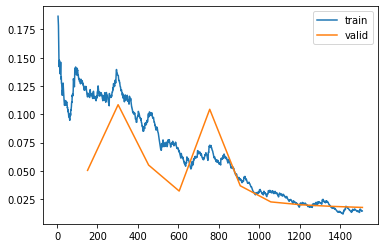

In [29]:
learner.recorder.plot_loss()

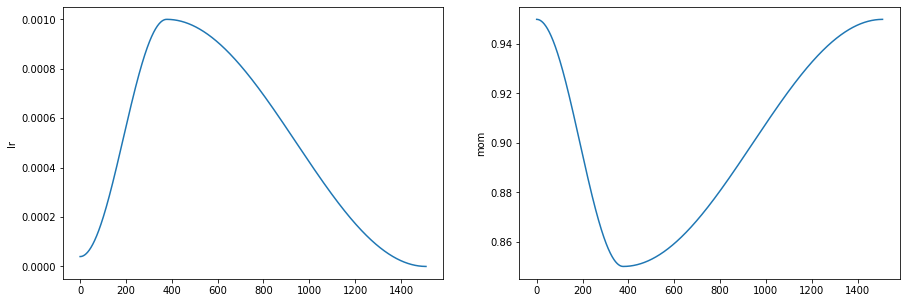

In [30]:
learner.recorder.plot_sched(figsize=(15,5))

In [31]:
learner.validate()

Better model found at epoch 0 with valid_loss value: 0.9950515627861023.


(#2) [0.01769186742603779,0.9950515627861023]

In [32]:
learner.save('stage-2')

Path('models/stage-2.pth')

# Checking Performance on Validation data

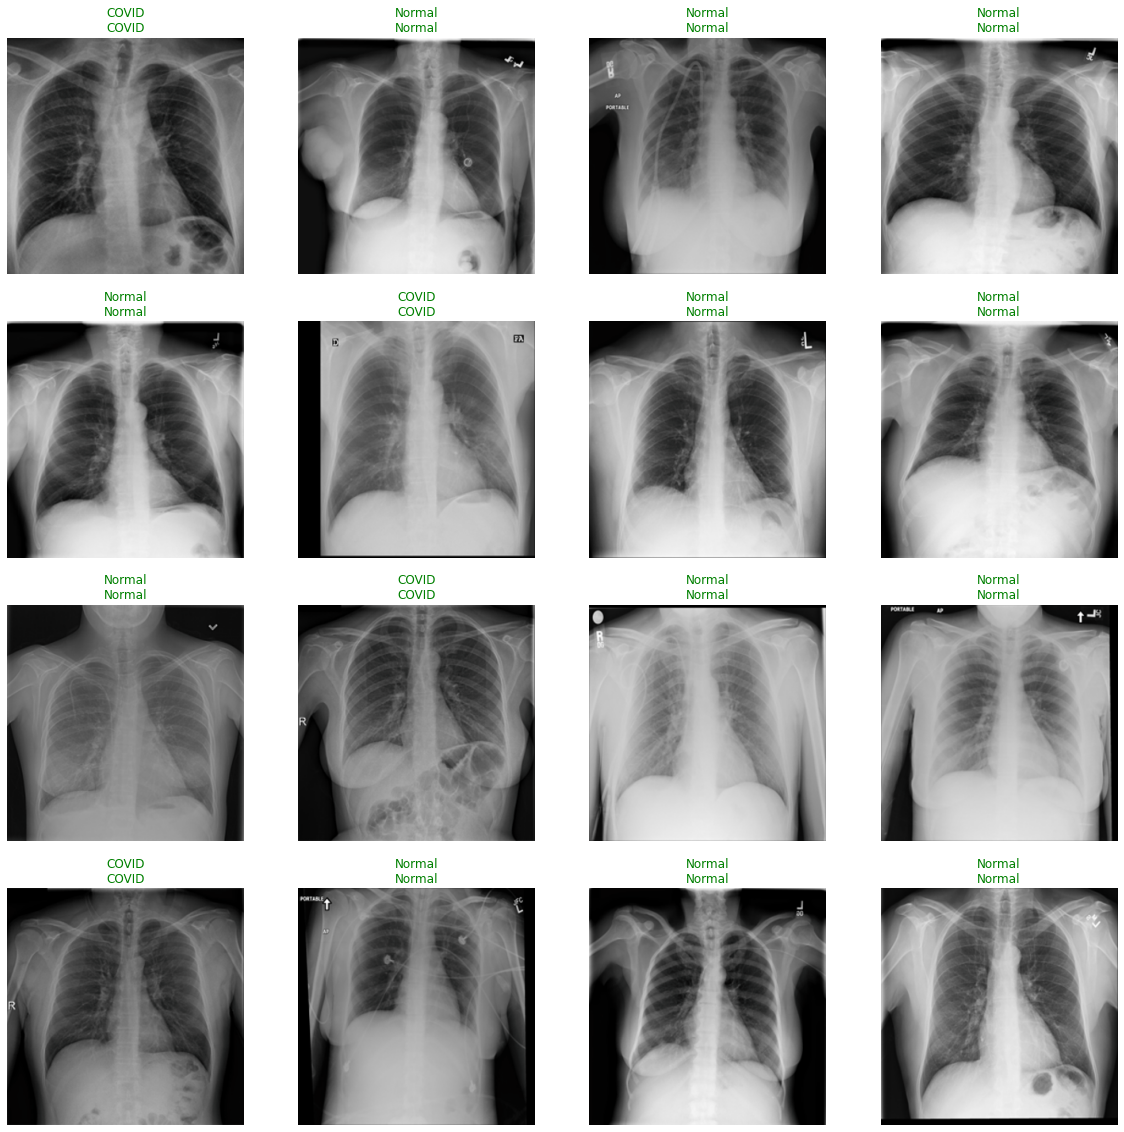

In [33]:
learner.show_results(max_n=16,figsize=(20,20))

In [34]:
valid_interp = ClassificationInterpretation.from_learner(learner,dl=valid_dls)

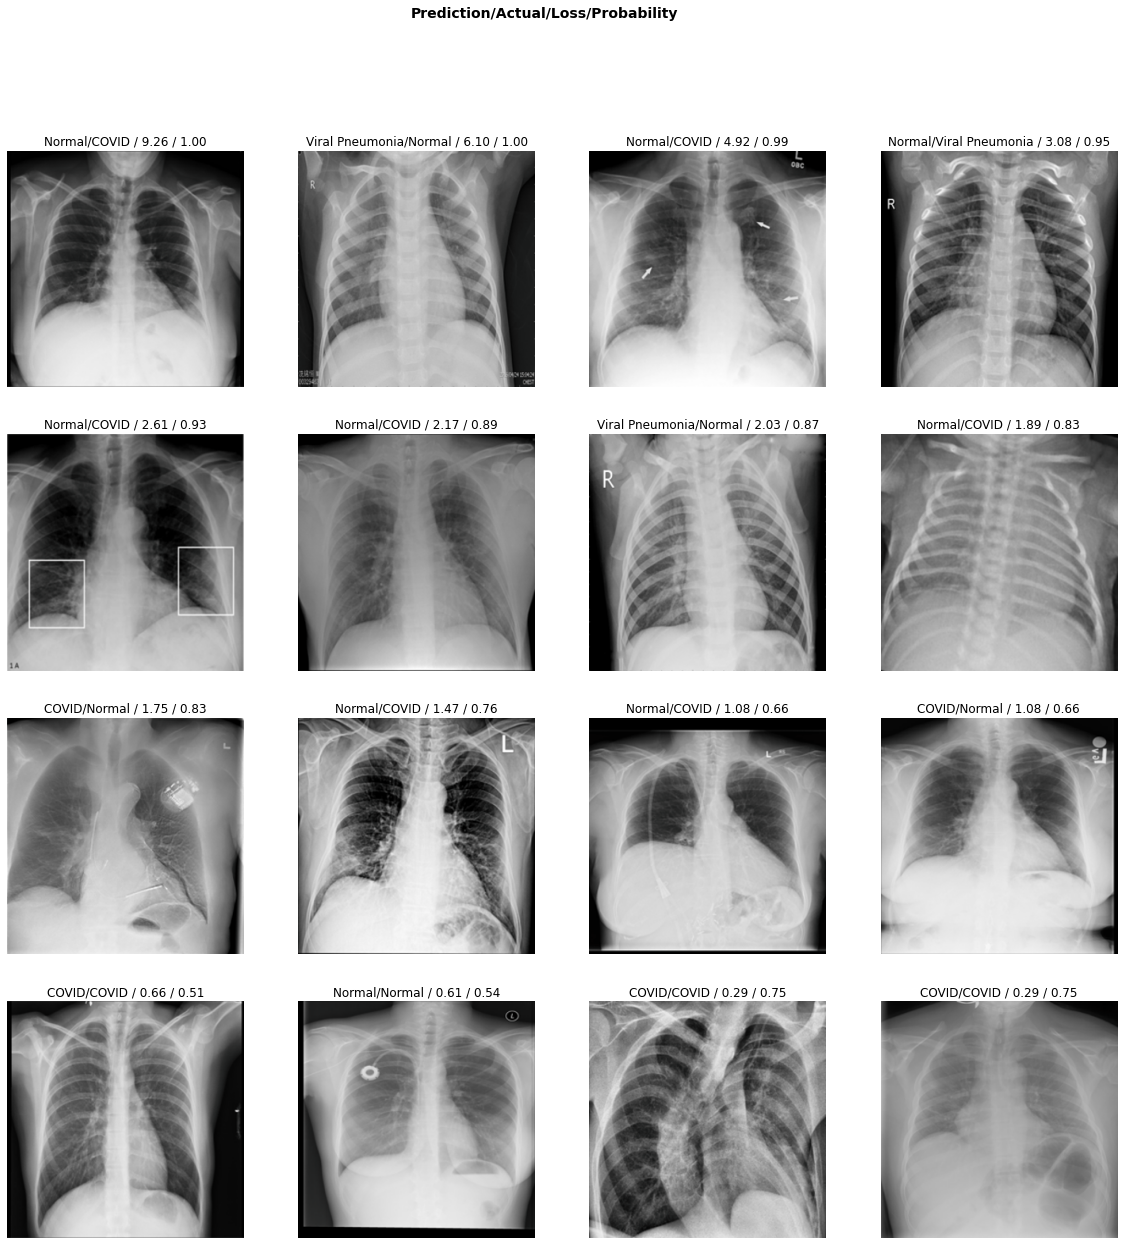

In [35]:
valid_interp.plot_top_losses(16, figsize=(20,20))

### - Plots images that gave maximum loss i.e poor performance... can help to see what is going most wrong and how to improve

                 precision    recall  f1-score   support

         Normal       1.00      1.00      1.00      1631
          COVID       1.00      0.99      0.99       579
Viral Pneumonia       0.99      1.00      0.99       215

       accuracy                           1.00      2425
      macro avg       0.99      0.99      0.99      2425
   weighted avg       1.00      1.00      1.00      2425



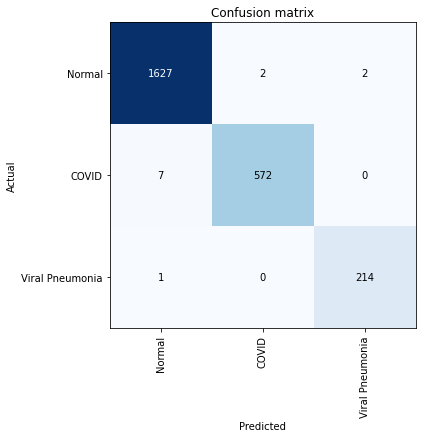

In [36]:
valid_interp.print_classification_report()
valid_interp.plot_confusion_matrix(figsize=(6,6))

In [37]:
learner.export() #save model for deployment

# Testing


In [38]:
test_interp = ClassificationInterpretation.from_learner(learner,dl=test_dls)

                 precision    recall  f1-score   support

         Normal       0.99      1.00      1.00      2039
          COVID       1.00      0.99      0.99       723
Viral Pneumonia       0.99      0.98      0.98       269

       accuracy                           0.99      3031
      macro avg       0.99      0.99      0.99      3031
   weighted avg       0.99      0.99      0.99      3031



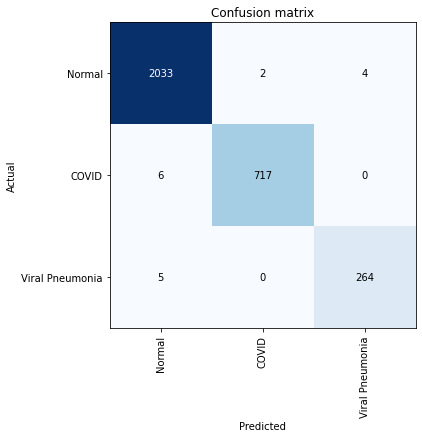

In [39]:
test_interp.print_classification_report()
test_interp.plot_confusion_matrix(figsize=(6,6))

# Test Time Augmentations



In practice, we get the predictions n times with the augmentations of the training set and average those. The final predictions are (1-beta) multiplied by this average + beta multiplied by the predictions obtained without the augmentations

In [40]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

def show_tta_results(dls, learner, vocab, **tta_kwargs): # report on validation data
    y_pred_ohe, y_true = learner.tta(dl=dls, **tta_kwargs)
    y_pred = np.argmax(y_pred_ohe.numpy(),axis=1)

    print('-'*60)
    print('Classification Report: ')
    print('-'*60)
    print(classification_report(y_true,y_pred))
    print('-'*60)
    print()
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true, y_pred),
                                  display_labels=vocab)
    disp.plot(cmap='Blues') 
    plt.title('Confusion Matrix')
    plt.show()

------------------------------------------------------------
Classification Report: 
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2039
           1       1.00      0.99      0.99       723
           2       0.99      0.98      0.99       269

    accuracy                           0.99      3031
   macro avg       0.99      0.99      0.99      3031
weighted avg       0.99      0.99      0.99      3031

------------------------------------------------------------



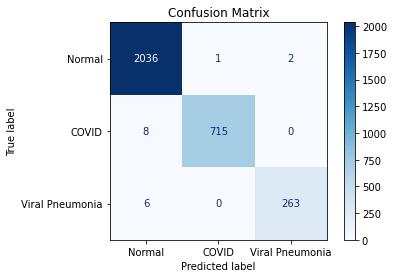

In [41]:
show_tta_results(test_dls, learner, vocab, n=4)